In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from CLPmodel import *

In [2]:
import pathlib
import fastmri
from fastmri.data import subsample
from fastmri.data import transforms as T, mri_data

# Create a mask function
mask_func = subsample.RandomMaskFunc(center_fractions=[0.08, 0.04], accelerations=[4, 8])

def data_transform(kspace, mask, target, data_attributes, filename, slice_num):
    # Transform the data into appropriate format
    
    crop_kspace = T.complex_center_crop(T.to_tensor(kspace), (320,320))

    masked_kspace, mask = T.apply_mask(T.to_tensor(kspace), mask_func)   # Apply the mask to k-space
    _, mask2 = T.apply_mask(crop_kspace, mask_func)
    
    ifft_masked_kspace = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
    crop_ifft_mk = T.complex_center_crop(ifft_masked_kspace, (320,320))
    #abs_masked_kspace = fastmri.complex_abs(crop_ifft_mk)   # Compute absolute value to get a real image
    
    original_img = fastmri.ifft2c(T.to_tensor(kspace))   #Inverse fourier transf. to the original image
    crop_original_img = T.complex_center_crop(original_img, (320,320))
    #abs_original_img = fastmri.complex_abs(crop_original_img)
    
    crop_ifft_mk = crop_ifft_mk.unsqueeze(0).unsqueeze(0)
    crop_original_img = crop_original_img.unsqueeze(0).unsqueeze(0)
    
    return crop_original_img, crop_ifft_mk, mask2

#def data_transform2(kspace, mask, target, data_attributes, filename, slice_num):
#    # Transform the data into appropriate format
#    
#    crop_kspace = T.complex_center_crop(T.to_tensor(kspace), (320,320))
#    
#    original_img = fastmri.ifft2c(T.to_tensor(kspace))   #Inverse fourier transf. to the original image
#    crop_original_img = T.complex_center_crop(original_img, (320,320))
#    abs_original_img = fastmri.complex_abs(crop_original_img)
#
#    crop_original_img = crop_original_img.unsqueeze(0).unsqueeze(0)
#    
#    return crop_original_img, abs_original_img

dataset = mri_data.SliceDataset(
    root=pathlib.Path('./mimmo'),
    transform=data_transform,
    challenge='singlecoil'
)

testset = mri_data.SliceDataset(
    root=pathlib.Path('./mimmo2'),
    transform=data_transform,
    challenge='singlecoil'
)

In [3]:
import torch.optim as optim

net = Net()

criterion = nn.L1Loss()
optimizer = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.95, amsgrad=False)

In [31]:
for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0
    i=0
    for crop_original_img, crop_ifft_mk, mask2 in dataset:
        
        optimizer.zero_grad()
        
        outputs = net(crop_original_img, crop_ifft_mk, mask2)
       
        figuraoutput = outputs.squeeze(0).squeeze(0)
        outputs_sample = fastmri.ifft2c(figuraoutput)  
        outputs_sample_abs = fastmri.complex_abs(outputs_sample)
        
        #fig = plt.figure()
        #plt.imshow(outputs_sample_abs.detach().numpy(), cmap='gray')
        #plt.savefig('pippo'+str(i)+'.jpg')
        
        original_img_abs = fastmri.complex_abs(crop_original_img.squeeze(0).squeeze(0))
        #fig = plt.figure()
        #plt.imshow(original_img_abs.detach().numpy(), cmap='gray')
        
        loss = criterion(outputs_sample_abs, original_img_abs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        print('Epoch n° (%d) loss: %.3f' % (epoch + 1, running_loss))
        
        i += 1
        #running_loss = 0.0
        #print(crop_ifft_mk.shape)
        #print(crop_original_img.shape)
        pass
    
print('Finished Training')

Cascade n° ( 1 )
Epoch n° (1) loss: 0.000
Cascade n° ( 1 )
Epoch n° (1) loss: 0.000
Cascade n° ( 1 )
Epoch n° (1) loss: 0.000
Cascade n° ( 1 )
Epoch n° (1) loss: 0.000
Cascade n° ( 1 )
Epoch n° (1) loss: 0.000
Cascade n° ( 1 )
Epoch n° (1) loss: 0.000
Cascade n° ( 1 )
Epoch n° (1) loss: 0.000
Cascade n° ( 1 )
Epoch n° (1) loss: 0.000
Cascade n° ( 1 )
Epoch n° (1) loss: 0.000
Cascade n° ( 1 )
Epoch n° (1) loss: 0.000
Cascade n° ( 1 )
Epoch n° (1) loss: 0.000
Cascade n° ( 1 )
Epoch n° (1) loss: 0.000
Cascade n° ( 1 )
Epoch n° (1) loss: 0.000
Cascade n° ( 1 )
Epoch n° (1) loss: 0.000
Cascade n° ( 1 )
Epoch n° (1) loss: 0.000
Cascade n° ( 1 )
Epoch n° (1) loss: 0.000
Cascade n° ( 1 )
Epoch n° (1) loss: 0.000
Cascade n° ( 1 )
Epoch n° (1) loss: 0.000
Cascade n° ( 1 )
Epoch n° (1) loss: 0.000
Cascade n° ( 1 )
Epoch n° (1) loss: 0.000
Cascade n° ( 1 )
Epoch n° (1) loss: 0.000
Cascade n° ( 1 )
Epoch n° (1) loss: 0.000
Cascade n° ( 1 )
Epoch n° (1) loss: 0.000
Cascade n° ( 1 )
Epoch n° (1) loss

In [32]:
PATH = './saved_net.pth'
torch.save(net.state_dict(), PATH)

net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

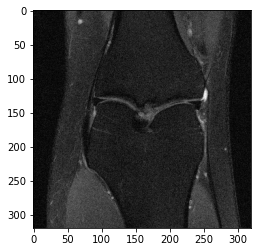

In [33]:
i=0
for crop_original_img, crop_ifft_mk, mask2 in testset:
    if i==20:
        pippo = fastmri.complex_abs(crop_original_img[0][0])
        fig = plt.figure()
        plt.imshow(pippo.detach().numpy(), cmap='gray')
    i+=1

Cascade n° ( 1 )
tensor(79.9817, grad_fn=<MeanBackward1>)
tensor(1.0000, grad_fn=<MeanBackward1>)
Cascade n° ( 1 )
tensor(79.9807, grad_fn=<MeanBackward1>)
tensor(1., grad_fn=<MeanBackward1>)
Cascade n° ( 1 )
tensor(79.9818, grad_fn=<MeanBackward1>)
tensor(1., grad_fn=<MeanBackward1>)
Cascade n° ( 1 )
tensor(79.9809, grad_fn=<MeanBackward1>)
tensor(1.0000, grad_fn=<MeanBackward1>)
Cascade n° ( 1 )
tensor(79.9811, grad_fn=<MeanBackward1>)
tensor(1., grad_fn=<MeanBackward1>)
Cascade n° ( 1 )
tensor(79.9801, grad_fn=<MeanBackward1>)
tensor(1.0000, grad_fn=<MeanBackward1>)
Cascade n° ( 1 )
tensor(79.9847, grad_fn=<MeanBackward1>)
tensor(1., grad_fn=<MeanBackward1>)
Cascade n° ( 1 )
tensor(79.9763, grad_fn=<MeanBackward1>)
tensor(1.0000, grad_fn=<MeanBackward1>)
Cascade n° ( 1 )
tensor(79.9723, grad_fn=<MeanBackward1>)
tensor(1.0000, grad_fn=<MeanBackward1>)
Cascade n° ( 1 )
tensor(79.9755, grad_fn=<MeanBackward1>)
tensor(1., grad_fn=<MeanBackward1>)
Cascade n° ( 1 )
tensor(79.9833, grad_fn

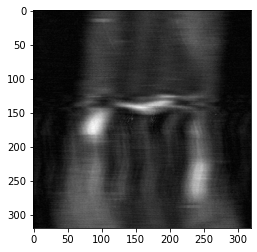

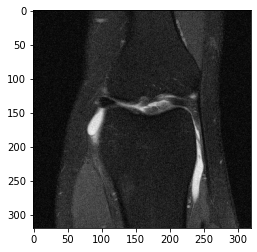

In [39]:
from piq import psnr, ssim

i=0
for crop_original_img2, crop_ifft_mk2,  mask22 in testset:
        
        outputs = net(crop_original_img2, crop_ifft_mk2, mask22)
        
        figuraoutput2 = outputs.squeeze(0).squeeze(0)
        sampled_image = fastmri.ifft2c(figuraoutput2)  
        sampled_image_abs = fastmri.complex_abs(sampled_image)
        
        crop_abs = fastmri.complex_abs(crop_original_img2[0][0])
        
        PSNR = psnr(sampled_image_abs,crop_abs)
        SSIM = ssim(sampled_image_abs,crop_abs)
        
        print(PSNR)
        print(SSIM)
        
        if i==15:
            fig = plt.figure()
            plt.imshow(sampled_image_abs.detach().numpy(), cmap='gray')
            
            fig = plt.figure()
            plt.imshow(crop_abs.detach().numpy(), cmap='gray')
        #plt.savefig('pippo'+str(i)+'.jpg')
        
        i += 1
        pass